In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_blobs
import sklearn 

In [2]:
def manipulate(diff=None):
    df = pd.read_csv("sibling.csv").rename(columns={"CASES": "Italy"}).round(0)
    # df = df[[x for x in df.columns if "_" not in x]]
    df = df[["Italy", "COUNTRY", "MONTH", "YEAR", "CONTINENT", "Belgium", "France", "Finland", "Germany", "Greece", "Spain", "United Kingdom", "Netherlands", "Liechtenstein", "Kosovo"]]
    if diff is not None:
        z = df[diff].copy(deep=True)
        for x in [y for y in df.columns if y not in ["COUNTRY", "MONTH"]]:
            df[x] = z - df[x] 
    df = pd.melt(df, id_vars = [x for x in df.columns if "COUNTRY"  in x or "MONTH" in x])
    # df = df[df["value"] != "Italy"].drop(columns=["variable"]).rename(columns={"CASES": "Italy"})
    df = pd.pivot_table(df, index=["COUNTRY", "variable"], columns=["MONTH"], aggfunc=np.sum).reset_index()
    df.columns = df.columns.to_series().str.join('_')
    df.columns = [x.replace("value_", "").replace("_", "") for x in df.columns]
    df.to_csv("sibling_manipulated.csv")
    return df

In [3]:
df = manipulate()
df

,COUNTRY,variable,2021-FEB,2021-JAN
0,Italy,Belgium,61730.0,76288.0
1,Italy,CONTINENT,74319.0,136936.0
2,Italy,Finland,14094.0,11050.0
3,Italy,France,493846.0,642963.0
4,Italy,Germany,216648.0,513032.0
5,Italy,Greece,41174.0,23847.0
6,Italy,Italy,430748.0,481292.0
7,Italy,Kosovo,10790.0,10293.0
8,Italy,Liechtenstein,68.0,304.0
9,Italy,Netherlands,115767.0,186524.0


In [202]:
def plot(max_iter = 300):

    i = 0
    charts = ["Italy", "Spain", "France", "Kosovo", "Greece"] # "All", 
    fig, axs = plt.subplots(len(charts), 2, figsize=(12, len(charts) * 3))

    for i, exclude in enumerate(charts):
        for j, comp in enumerate([True, False]):
            if comp:
                df = manipulate(exclude)
            else:
                df = manipulate()

            X = df[df["variable"] != exclude]
            X = X[["2021-JAN", "2021-FEB"]]
            X = X.to_numpy()

            # #############################################################################
            # Compute Kmedoids clustering
            cobj = KMedoids(n_clusters=3, random_state=0, init='k-medoids++', max_iter=max_iter).fit(X) # 
            labels = cobj.labels_

            unique_labels = set(labels)
            colors = [
                plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
            ]

            for k, col in zip(unique_labels, colors):
                class_member_mask = labels == k
                xy = X[class_member_mask]
                axs[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor="black",# tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            df.apply(lambda x: axs[i][j].text(x["2021-JAN"], x["2021-FEB"], x["variable"]), axis=1)

            # axs[i][j].plot(
            #     cobj.cluster_centers_[:, 0],
            #     cobj.cluster_centers_[:, 1],
            #     "o",
            #     markerfacecolor="cyan",
            #     markeredgecolor="k",
            #     markersize=10,
            # )

            axs[i][j].set_title(exclude)
            axs[i][j].set_ylim([df["2021-FEB"].min(), df["2021-JAN"].max()]) # df["2021-FEB"].max()
            axs[i][j].set_xlim([df["2021-JAN"].min(), df["2021-JAN"].max()])
            axs[i][j].set_xlabel("cases ('2021-JAN')")
            axs[i][j].set_ylabel("cases ('2021-FEB')") 
            # plt.title("KMedoids clustering. Medoids are represented in cyan.")
            # plt.savefig("sibling.svg")
    fig.tight_layout()

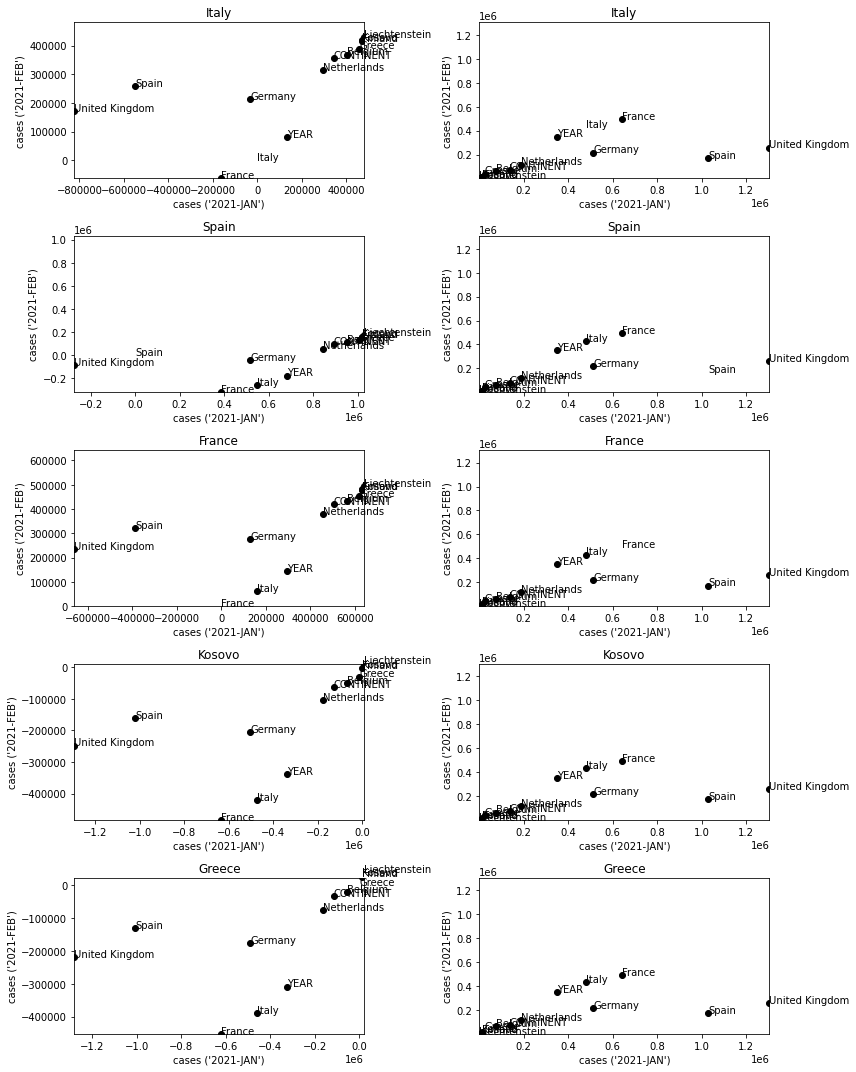

In [203]:
plot()

In [195]:
def get_kmeans_pp_centroids(X1, k = 3):
    
    centroids = X1.sample(random_state=15)
    print(centroids)
    print("--")
    X1 = X1.drop(centroids.index)
    # random_state = 0 -> Italy
    # random_state = 2 -> Germany
    # random_state = 4 -> France
    # random_state = 6 -> Finland
    # random_state = 12 -> Liechtenstein
    i = 1
    dist = []
    while i != k:
        max_dist = [0, 0]
        # go through the centroids
        for index, row in centroids.iterrows():
            # calculate distance of every centroid with every other data point 
            d = np.sqrt((X1["2021-JAN"] - row["2021-JAN"]) ** 2 + (X1["2021-FEB"] - row["2021-FEB"]) ** 2)
            # check which centroid has a max distance with another point
            if max(d) > max(max_dist):
                max_dist = d
        X1 = pd.concat([X1, pd.DataFrame(max_dist, columns=[i])], axis = 1)
        print(X1)
        print("--")
        # idx = X1.iloc[:, i + 1].idxmax()
        idx = X1[i].idxmax()
        print(idx)
        print("-- idx --")
        max_coor = pd.DataFrame(X1.loc[idx][["2021-JAN", "2021-FEB"]]).T
        print(max_coor)
        print("-- max_coor --")
        centroids = pd.concat([centroids, max_coor])
        X1 = X1.drop(idx)
        i += 1
    return centroids

df = manipulate()
centroids = get_kmeans_pp_centroids(df[["2021-JAN", "2021-FEB"]])
df.merge(centroids, on=["2021-JAN", "2021-FEB"])

     2021-JAN  2021-FEB
10  1030241.0  171885.0
--
     2021-JAN  2021-FEB             1
0     76288.0   61730.0  9.602919e+05
1    136936.0   74319.0  8.986172e+05
2     11050.0   14094.0  1.031333e+06
3    642963.0  493846.0  5.036300e+05
4    513032.0  216648.0  5.191424e+05
5     23847.0   41174.0  1.014847e+06
6    481292.0  430748.0  6.069226e+05
7     10293.0   10790.0  1.032592e+06
8       304.0      68.0  1.044170e+06
9    186524.0  115767.0  8.455812e+05
11  1305005.0  258736.0  2.881638e+05
12   349588.0  349588.0  7.034677e+05
--
8
-- idx --
   2021-JAN  2021-FEB
8     304.0      68.0
-- max_coor --
     2021-JAN  2021-FEB             1             2
0     76288.0   61730.0  9.602919e+05  9.785587e+04
1    136936.0   74319.0  8.986172e+05  1.555041e+05
2     11050.0   14094.0  1.031333e+06  1.766933e+04
3    642963.0  493846.0  5.036300e+05  8.104488e+05
4    513032.0  216648.0  5.191424e+05  5.565940e+05
5     23847.0   41174.0  1.014847e+06  4.737062e+04
6    481292.0  43

,COUNTRY,variable,2021-FEB,2021-JAN
0,Italy,Liechtenstein,68.0,304.0
1,Italy,Spain,171885.0,1030241.0
2,Italy,United Kingdom,258736.0,1305005.0


In [200]:
def get_kmeans_pp_centroids(X1, k = 3):
    
    centroids = X1.sample(random_state=15)
    print(centroids)
    print("--")
    X1 = X1.drop(centroids.index)
    # random_state = 0 -> Italy
    # random_state = 2 -> Germany
    # random_state = 4 -> France
    # random_state = 6 -> Finland
    # random_state = 12 -> Liechtenstein
    # 15 Spain
    i = 1
    dist = []
    while i != k:
        max_dist = []
        # go through the centroids
        for index, row in centroids.iterrows():
            # calculate distance of every centroid with every other data point 
            d = np.sqrt((X1["2021-JAN"] - row["2021-JAN"]) ** 2 + (X1["2021-FEB"] - row["2021-FEB"]) ** 2)
            # check which centroid has a max distance with another point
            if len(max_dist) == 0:
                max_dist = d
            else:
                max_dist = pd.concat([max_dist, d], axis=1).min(axis=1)

        X1 = pd.concat([X1, pd.DataFrame(max_dist, columns=[i])], axis = 1)
        print(X1)
        print("--")
        # idx = X1.iloc[:, i + 1].idxmax()
        idx = X1[i].idxmax()
        print(idx)
        print("-- idx --")
        max_coor = pd.DataFrame(X1.loc[idx][["2021-JAN", "2021-FEB"]]).T
        print(max_coor)
        print("-- max_coor --")
        centroids = pd.concat([centroids, max_coor])
        X1 = X1.drop(idx)
        i += 1
    return centroids

df = manipulate()
centroids = get_kmeans_pp_centroids(df[["2021-JAN", "2021-FEB"]])
df.merge(centroids, on=["2021-JAN", "2021-FEB"])

     2021-JAN  2021-FEB
10  1030241.0  171885.0
--
     2021-JAN  2021-FEB             1
0     76288.0   61730.0  9.602919e+05
1    136936.0   74319.0  8.986172e+05
2     11050.0   14094.0  1.031333e+06
3    642963.0  493846.0  5.036300e+05
4    513032.0  216648.0  5.191424e+05
5     23847.0   41174.0  1.014847e+06
6    481292.0  430748.0  6.069226e+05
7     10293.0   10790.0  1.032592e+06
8       304.0      68.0  1.044170e+06
9    186524.0  115767.0  8.455812e+05
11  1305005.0  258736.0  2.881638e+05
12   349588.0  349588.0  7.034677e+05
--
8
-- idx --
   2021-JAN  2021-FEB
8     304.0      68.0
-- max_coor --
     2021-JAN  2021-FEB             1              2
0     76288.0   61730.0  9.602919e+05   97855.865946
1    136936.0   74319.0  8.986172e+05  155504.065622
2     11050.0   14094.0  1.031333e+06   17669.329133
3    642963.0  493846.0  5.036300e+05  503629.958208
4    513032.0  216648.0  5.191424e+05  519142.442736
5     23847.0   41174.0  1.014847e+06   47370.624706
6    48129

,COUNTRY,variable,2021-FEB,2021-JAN
0,Italy,Italy,430748.0,481292.0
1,Italy,Liechtenstein,68.0,304.0
2,Italy,Spain,171885.0,1030241.0


In [189]:
from sklearn.cluster import kmeans_plusplus
df = manipulate()

random_state=3
centers, indices = kmeans_plusplus(df[["2021-JAN", "2021-FEB"]].to_numpy(), n_clusters=3) # , random_state=random_state
X = pd.DataFrame(data=centers, columns=["2021-JAN", "2021-FEB"])
df.merge(X, on=["2021-JAN", "2021-FEB"])

,COUNTRY,variable,2021-FEB,2021-JAN
0,Italy,Finland,14094.0,11050.0
1,Italy,France,493846.0,642963.0
2,Italy,Spain,171885.0,1030241.0


In [35]:
centers, indices = kmeans_plusplus(df[["2021-JAN", "2021-FEB"]].to_numpy(), n_clusters=3, n_local_trials=1, random_state=random_state)
X = pd.DataFrame(data=centers, columns=["2021-JAN", "2021-FEB"])
df.merge(X, on=["2021-JAN", "2021-FEB"])

,COUNTRY,variable,2021-FEB,2021-JAN
0,Italy,Liechtenstein,68.0,304.0
1,Italy,Spain,171885.0,1030241.0
2,Italy,YEAR,349588.0,349588.0
